In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, special, linalg
import healpy as hp
import emcee, tqdm, corner
import scipy.optimize

In [3]:
import pystan

## Demo pystan code

In [5]:
schools_code = """
data {
  int<lower=0> J;         // number of schools
  real y[J];              // estimated treatment effects
  real<lower=0> sigma[J]; // standard error of effect estimates
}
parameters {
  real mu;                // population treatment effect
  real<lower=0> tau;      // standard deviation in treatment effects
  vector[J] eta;          // unscaled deviation from mu by school
}
transformed parameters {
  vector[J] theta = mu + tau * eta;        // school treatment effects
}
model {
  target += normal_lpdf(eta | 0, 1);       // prior log-density
  target += normal_lpdf(y | theta, sigma); // log-likelihood
}
"""

schools_data = {"J": 8,
                "y": [28,  8, -3,  7, -1,  1, 18, 12],
                "sigma": [15, 10, 16, 11,  9, 11, 10, 18]}

In [6]:
sm = pystan.StanModel(model_code=schools_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67cb7d0f2cb7720776cbeb52007d2dbb NOW.


array([[-5.27135743e-01, -1.16119742e-01,  4.11324886e-01, ...,
         1.03737856e+00,  8.42396182e-01, -1.09887583e-02],
       [ 1.07615379e+00,  1.67879702e+00,  1.63166245e+00, ...,
        -1.25432501e+00,  1.30118871e+00, -2.54862169e+00],
       [ 1.75074746e+00,  5.08537992e-01, -3.49046726e-02, ...,
         8.71268829e-02,  3.81690422e-01,  4.16954303e-01],
       ...,
       [-5.90591310e-01,  3.18128106e-01, -9.08854739e-01, ...,
         2.94125512e-01,  9.31107924e-02,  4.23821002e-01],
       [ 1.52478416e+00, -4.85172536e-01, -3.40595232e-01, ...,
         6.24284959e-01, -1.17993561e+00,  1.39267436e-01],
       [ 6.01127148e-01,  3.43398687e-04, -5.04834189e-01, ...,
        -3.79081196e-01, -1.02186776e-01,  3.17969753e-02]])

In [ ]:
fit = sm.sampling(data=schools_data, iter=1000, chains=4, seed=1)
fit.extract()["eta"]  # array with shape (2000, 8)

## Demo 1D binomial likelihood

In [ ]:
def nloglike_grad(params, k, n, hpx, nlm):
    x = np.sum(params*Ylm_grid, axis=1)[hpx]
    
    exp_x = np.exp(x)
    log1p_exp_x = np.log1p(exp_x)
    
    logl = np.sum( k*x - n*log1p_exp_x )
    
    grad_norm = k - n*exp_x/log1p_exp_x
    grad = np.sum(grad_norm[:,None] * Ylm_grid[hpx], axis=1)
    
    return -logl, -grad

In [17]:
binomial_code = """
data {
  int<lower=0> k;         // astrometry sample
  int<lower=0> n;         // full sample
}
parameters {
  real x;                // logit selection probability
}
transformed parameters {
}
model {
  x ~ std_normal();        // log-prior
  k ~ binomial_logit(n, x);   // log-likelihood
}
"""

In [18]:
binomial_data = {"k": 7,
                "n": 10}

In [19]:
%time bn = pystan.StanModel(model_code=binomial_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_74fc09fa1d679c41361fa2c9745dbf49 NOW.


In [20]:
fit = bn.sampling(data=binomial_data, iter=1000, chains=4, seed=1)

In [21]:
fit.extract()["x"].shape  # array with shape (2000, 8)

(2000,)

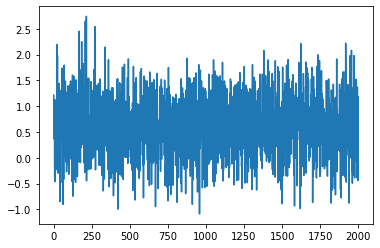

In [22]:
plt.plot(fit.extract()["x"])

(array([0.000898  , 0.001796  , 0.000898  , 0.001796  , 0.00538801,
        0.00449001, 0.00898001, 0.01885802, 0.02514403, 0.04220605,
        0.07004409, 0.09608612, 0.14008817, 0.1661302 , 0.26221632,
        0.29903437, 0.38075247, 0.47683859, 0.47683859, 0.5639447 ,
        0.64117279, 0.63219278, 0.61333476, 0.60884475, 0.56304669,
        0.51275863, 0.46157257, 0.38703848, 0.33675042, 0.26131832,
        0.22629628, 0.18049822, 0.14727218, 0.10865813, 0.07633009,
        0.04849206, 0.04400205, 0.03143004, 0.01975602, 0.01526602,
        0.003592  , 0.00628601, 0.001796  , 0.001796  , 0.002694  ,
        0.000898  , 0.001796  , 0.        , 0.000898  , 0.001796  ]),
 array([-1.74542785, -1.63406941, -1.52271098, -1.41135254, -1.2999941 ,
        -1.18863567, -1.07727723, -0.96591879, -0.85456035, -0.74320192,
        -0.63184348, -0.52048504, -0.4091266 , -0.29776817, -0.18640973,
        -0.07505129,  0.03630714,  0.14766558,  0.25902402,  0.37038246,
         0.48174089,  0.59

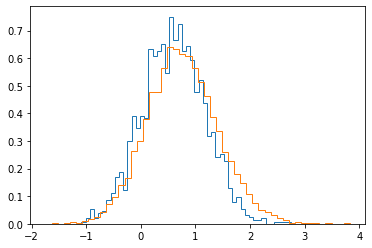

In [26]:
plt.hist(fit.extract()["x"], bins=50,histtype='step',density=True);
plt.hist(special.logit(np.random.beta(8,4,10000)),50,histtype='step',density=True)

In [ ]:
plt.plot

## N-D binomial likelihood

In [120]:
binomial_code = """
functions{
}
data {
  int<lower=0> J;            // number of data points
  vector[J] k;               // astrometry sample
  vector[J] n;               // full sample
}
parameters {
  vector[J] x;               // logit selection probability
}
transformed parameters {
}
model {
  target += normal_lpdf(x | 0,1);        // log-prior
  target += k .*x - n .*log(1+exp(x));   // log-likelihood
}
"""

In [93]:
binomial_code = """
functions{
    real binomial_loglike(int J, vector k, vector n, vector x){
        real loglike = 0.;
          for (i in 1:J){
            loglike += k[i]*x[i] - n[i]*log(1+exp(x[i]));
          }
        return loglike;
    }
}
data {
  int<lower=0> J;            // number of data points
  vector[J] k;               // astrometry sample
  vector[J] n;               // full sample
}
parameters {
  vector[J] x;               // logit selection probability
}
transformed parameters {
}
model {
  target += normal_lpdf(x | 0,1);        // log-prior
  target += binomial_loglike(J,k,n,x);   // log-likelihood
}
"""

In [121]:
bn = pystan.StanModel(model_code=binomial_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_375988f09bbf96e1382a35e3f9692d3c NOW.


In [115]:
def expit(x):
    return np.exp(x)/(1+np.exp(x))

x = np.random.normal(0,1,size=5)
p = expit(x)
n = np.random.choice(np.arange(20, 100), size=5, replace=False)
k = scipy.stats.binom.rvs(n,p)

In [116]:
binomial_data = {"J":5,
                 "k": k,
                "n": n}

In [122]:
fit = bn.sampling(data=binomial_data, iter=1000, chains=10, seed=1)

In [118]:
import corner

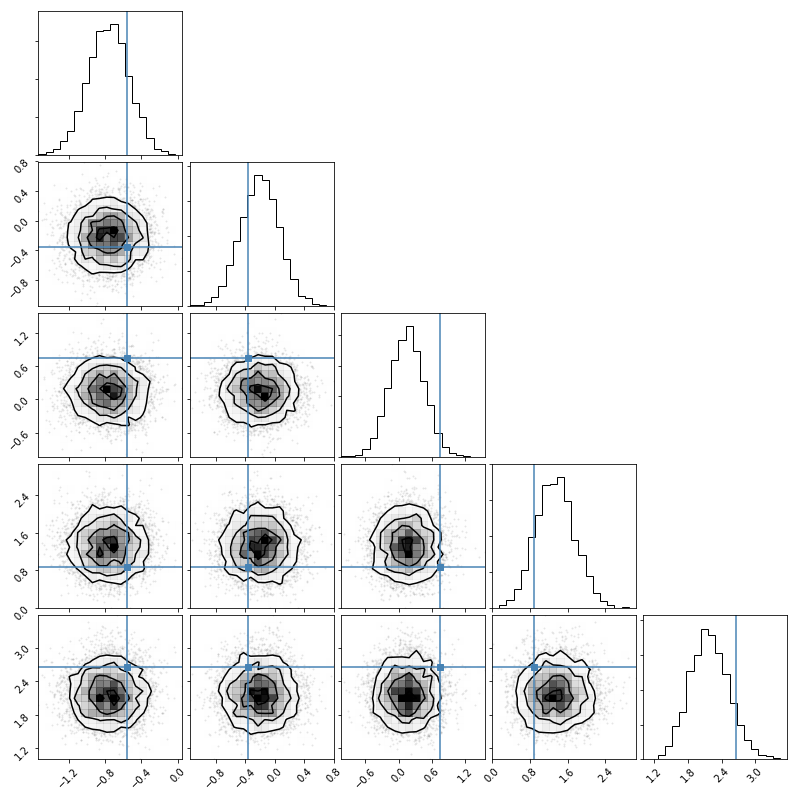

In [124]:
corner.corner(fit.extract()['x'], truths=x);

# Run spherical harmonics

## Initialise logit probabilities

In [24]:
lmax=10
nlm = int(lmax*(lmax+1)/2+0.01); 
nside=128

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


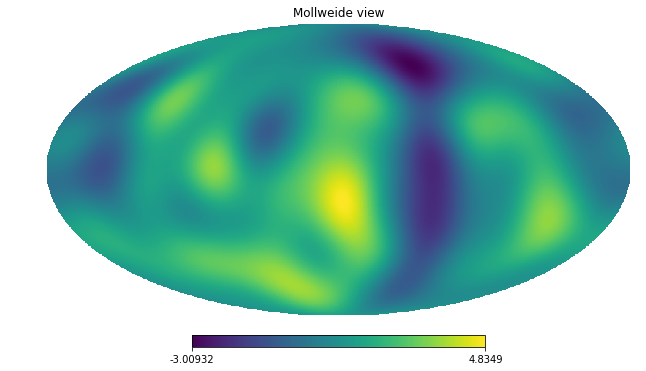

In [25]:
lmax = 10
l = hp.sphtfunc.Alm.getlm(lmax=lmax-1)[0]
scale = 10.0/(1.0+l)**2
_alm = np.random.normal(0,scale,int(lmax*(lmax+1)/2)) + 1j*np.random.normal(0,scale,int(lmax*(lmax+1)/2))
_map = hp.sphtfunc.alm2map(_alm,nside=nside)
hp.mollview(_map)

In [31]:
%timeit hp.sphtfunc.alm2map(_alm,nside=64, verbose=False)

536 µs ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%timeit hp.sphtfunc.alm2map(_alm,nside=128, verbose=False)

1.7 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%timeit hp.sphtfunc.alm2map(_alm,nside=256, verbose=False)

8.72 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
%timeit hp.sphtfunc.alm2map(_alm,nside=512, verbose=False)

34.4 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
# generate sph harm grid
nside=512
Ylm_grid = np.zeros((2*nlm, hp.nside2npix(nside)))
for ii in tqdm.tqdm_notebook(range(nlm)):
    alm_grid = np.zeros(nlm)
    alm_grid[ii]=1
    Ylm_grid[ii] = hp.sphtfunc.alm2map(alm_grid+0.j*alm_grid,nside=nside,verbose=False)
    Ylm_grid[nlm+ii] = hp.sphtfunc.alm2map(0.*alm_grid+1.j*alm_grid,nside=nside,verbose=False)

In [35]:
# nside=64
%timeit Ylm_grid.T@_alm_flat

6.11 ms ± 758 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
# nside=128
%timeit Ylm_grid.T@_alm_flat

17.5 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
# nside=256
%timeit Ylm_grid.T@_alm_flat

60.4 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
# nside=512
%timeit Ylm_grid.T@_alm_flat

285 ms ± 46.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
Ylm_grid.shape

(110, 196608)

In [13]:
_alm.shape

(55,)

In [29]:
_alm_flat = np.hstack((np.real(_alm), np.imag(_alm)))

In [30]:
%timeit Ylm_grid.T@_alm_flat

15.7 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Draw sample

In [12]:
def expit(x):
    return np.exp(x)/(1+np.exp(x))

In [13]:
sample = {}
sample['hpx'] = np.random.choice(np.arange(hp.nside2npix(nside)), size=int(1e6), replace=True)
sample['p'] = expit(_map[sample['hpx']])
sample['selected'] = (np.random.rand(len(sample['hpx'])) < sample['p']).astype(int)

## Accumulate sample in bins

In [14]:
k = stats.binned_statistic(sample['hpx'], sample['selected'], 
                       bins=np.arange(hp.nside2npix(nside)+1)-0.5, statistic='sum').statistic
n = stats.binned_statistic(sample['hpx'], sample['selected'], 
                       bins=np.arange(hp.nside2npix(nside)+1)-0.5, statistic='count').statistic

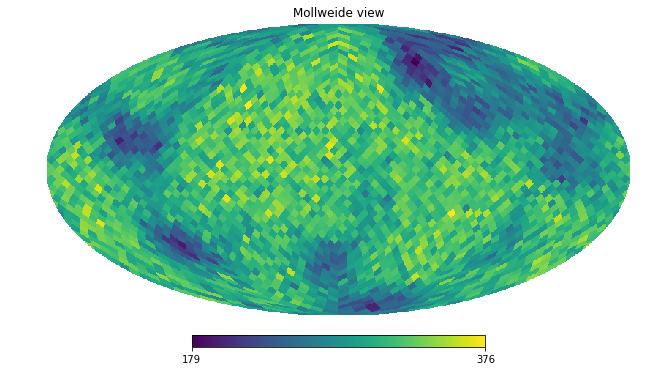

In [15]:
hp.mollview(k)

In [16]:
# generate sph harm grid
Ylm_grid = np.zeros((2*nlm, hp.nside2npix(nside)))
for ii in tqdm.tqdm_notebook(range(nlm)):
    alm_grid = np.zeros(nlm)
    alm_grid[ii]=1
    Ylm_grid[ii] = hp.sphtfunc.alm2map(alm_grid+0.j*alm_grid,nside=nside,verbose=False)
    Ylm_grid[nlm+ii] = hp.sphtfunc.alm2map(0.*alm_grid+1.j*alm_grid,nside=nside,verbose=False)

In [18]:
binomial_code = """
functions{
}
data {
  int<lower=0> J;            // number of pixels
  int<lower=0> H;            // number of harmonics
  vector[J] k;               // astrometry sample counts
  vector[J] n;               // full sample counts
  matrix[J,H] Ylm;             // spherical harmonics
}
parameters {
  vector[H] alm;               // logit selection probability
}
transformed parameters {
  vector[J] x = Ylm * alm;
}
model {
  target += normal_lpdf(alm | 0,1);        // log-prior
  target += k .*x - n .*log(1+exp(x));   // log-likelihood
}
"""

In [19]:
bn = pystan.StanModel(model_code=binomial_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5f64eeb262d007a1cf64c432a1a9eb1 NOW.


In [20]:
binomial_data = {"J":hp.nside2npix(nside),
                 "H":2*nlm,
                 "k": k,
                 "n": n,
                 "Ylm": Ylm_grid.T}

In [ ]:
fit = bn.sampling(data=binomial_data, iter=1000, chains=4, seed=1, n_jobs=1)